In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
from PIL import Image

In [4]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [59]:
img =  load_img('/usr/not-backed-up/temp/NYU/images/0000.png')

In [90]:
img.save('0.png')

In [26]:
npimg = img_to_array(img)

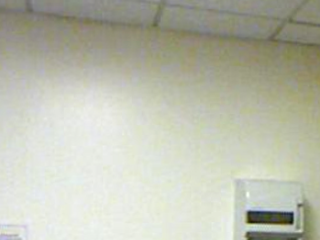

In [88]:
npimg = img_to_array(img)
aug = augment(npimg)
array_to_img(aug)

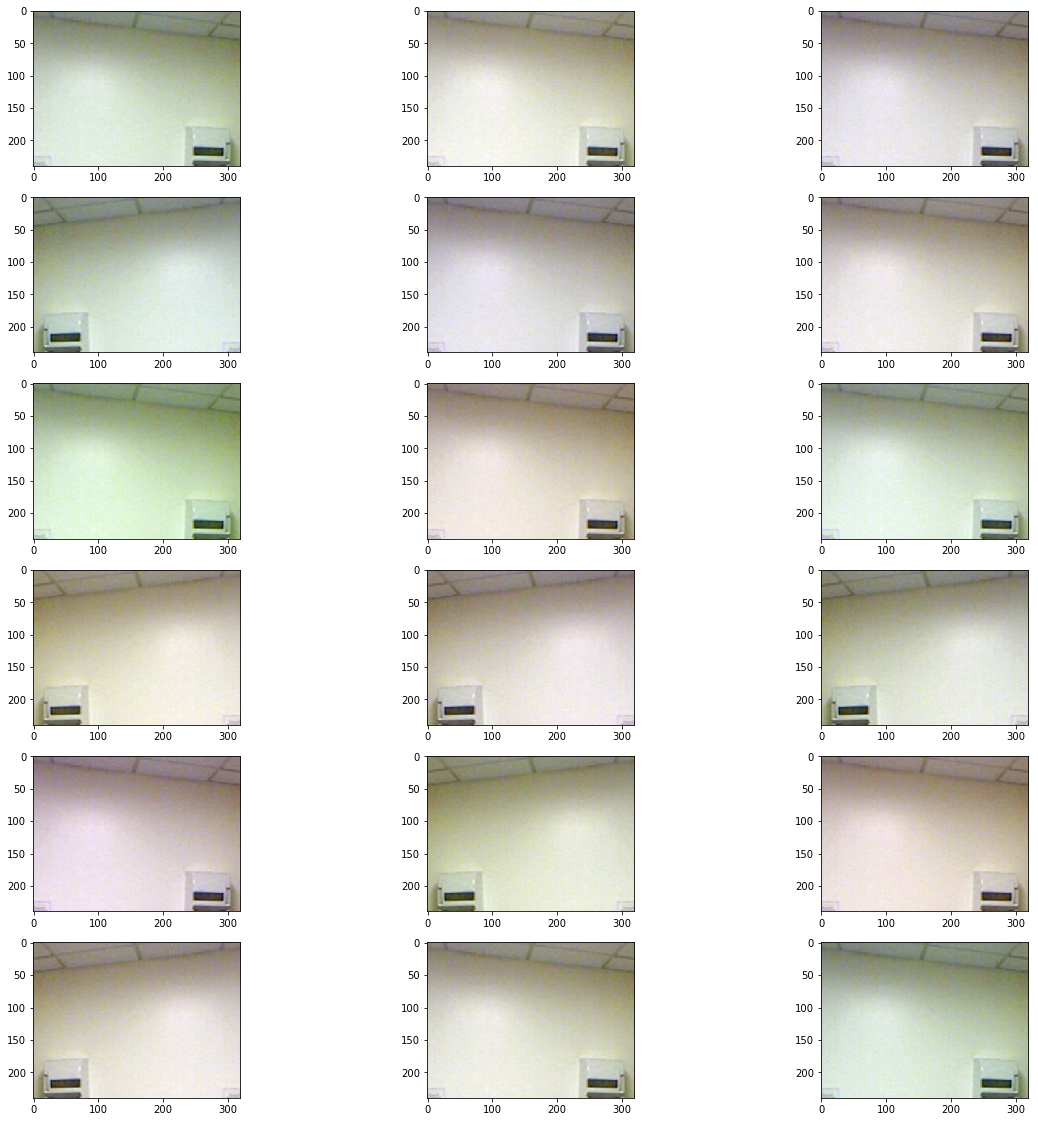

In [89]:
npaug = aug.reshape((1,) + aug.shape)
datagen = ImageDataGenerator(
    channel_shift_range=10,
    horizontal_flip=True,
    )
i = 0;
nrows = 6;
ncols = 3;
fig, axes = plt.subplots(nrows, ncols,figsize=(20,20))
for batch in datagen.flow(npaug, batch_size=1,save_to_dir='./output/'):
    i += 1;
    plt.subplot(nrows,ncols,i)
    plt.imshow(array_to_img(batch[0]))
    if i == nrows*ncols:
        break
plt.show()

In [58]:
npimg = npimg.reshape((1,) + npimg.shape)

In [231]:
datagen = ImageDataGenerator(
    channel_shift_range=10,
    horizontal_flip=True,
    preprocessing_function=augment
    )

In [232]:
i = 0;
nrows = 6;
ncols = 3;
fig, axes = plt.subplots(nrows, ncols,figsize=(20,20))
for batch in datagen.flow(npimg, batch_size=1):
    i += 1;
    plt.subplot(nrows,ncols,i)
    plt.imshow(array_to_img(batch[0]))
    if i == nrows*ncols:
        break
plt.show()

ValueError: could not broadcast input array from shape (240,320,3) into shape (427,561,3)

In [8]:
import scipy.ndimage as ndi

def random_rotation(x, rg, row_axis=0, col_axis=1, channel_axis=2,
                    fill_mode='nearest', cval=0., order=3):
    """Performs a random rotation of a Numpy image tensor.
    # Arguments
        x: Input tensor. Must be 3D.
        rg: Rotation range, in degrees.
        row_axis: Index of axis for rows in the input tensor.
        col_axis: Index of axis for columns in the input tensor.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
        order: The order of the spline interpolation, default is 3. 
            The order has to be in the range 0-5.
    # Returns
        Rotated Numpy image tensor.
    """
    theta = np.pi / 180 * np.random.uniform(-rg, rg)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])

    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = transform_matrix_offset_center(rotation_matrix, h, w)
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval, order)
    return x

def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix

def apply_transform(x,
                    transform_matrix,
                    channel_axis=0,
                    fill_mode='nearest',
                    cval=0.,
                    order = 3):
    """Apply the image transformation specified by a matrix.
    # Arguments
        x: 2D numpy array, single image.
        transform_matrix: Numpy array specifying the geometric transformation.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
        order: The order of the spline interpolation, default is 3. 
            The order has to be in the range 0-5.
    # Returns
        The transformed version of the input.
    """
    x = np.rollaxis(x, channel_axis, 0)
    final_affine_matrix = transform_matrix[:2, :2]
    final_offset = transform_matrix[:2, 2]
    channel_images = [ndi.interpolation.affine_transform(
        x_channel,
        final_affine_matrix,
        final_offset,
        order=order,
        mode=fill_mode,
        cval=cval) for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x

In [9]:
from math import ceil
def random_resize(npimg, minwidth=320, minheight=240, resample=Image.BICUBIC):
    """Returns a random resized copy of a Numpy image tensor.
    # Arguments
        npimg: Input tensor. Must be 3D.
        minwidth: Minimum width of resized image.
        minheight: Minimum height of resized image.
        resample: An optional resampling filter. 
            This can be one of PIL.Image.NEAREST, PIL.Image.BOX, PIL.Image.BILINEAR,
            PIL.Image.HAMMING, PIL.Image.BICUBIC or PIL.Image.LANCZOS. 
            If omitted, it is set PIL.Image.BICUBIC.
    # Returns
        Resized Numpy image tensor.
    """
    img = array_to_img(npimg)
    smallestResizeFactor = max(ceil((minwidth / img.size[0])*100) , ceil((minheight / img.size[1])*100))
    resizeFactor = 0.01 * np.random.randint(smallestResizeFactor,140) # In range of [Min_Width_Height, 1.4*original_size] 
    img = img.resize((int(img.size[0]*resizeFactor),int(img.size[1]*resizeFactor)),resample=resample)
    return img_to_array(img)

In [10]:
from keras import backend as K

def random_crop(npimg, width=320, height=240, data_format=None):
    """Returns a random cropped copy of a Numpy image tensor.
    # Arguments
        npimg: Input tensor. Must be 3D.
        width: width of crop region.
        height: height of crop region.
        data_format: Image data format. One of "channels_first" or "channels_last"
    # Returns
        Cropped Numpy image tensor.
    """
    if npimg.ndim != 3:
        raise ValueError('Expected image array to have rank 3 (single image). '
                         'Got array with shape:', npimg.shape)

    if data_format is None:
        data_format = K.image_data_format()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Invalid data_format:', data_format)

    # Original Numpy array x has format (height, width, channel)
    # or (channel, height, width)
    if data_format == 'channels_first':
        npimg = npimg.transpose(1, 2, 0)
    
    maxHeightIndex = npimg.shape[0] - height
    heightIndex = np.random.randint(0,maxHeightIndex)
    
    maxWidthIndex = npimg.shape[1] - width
    widthIndex = np.random.randint(0,maxWidthIndex)
    
    crop = npimg[heightIndex:heightIndex+height,widthIndex:widthIndex+width,:]
    
    if data_format == 'channels_first':
        crop = crop.transpose(2, 0, 1)
    
    return crop

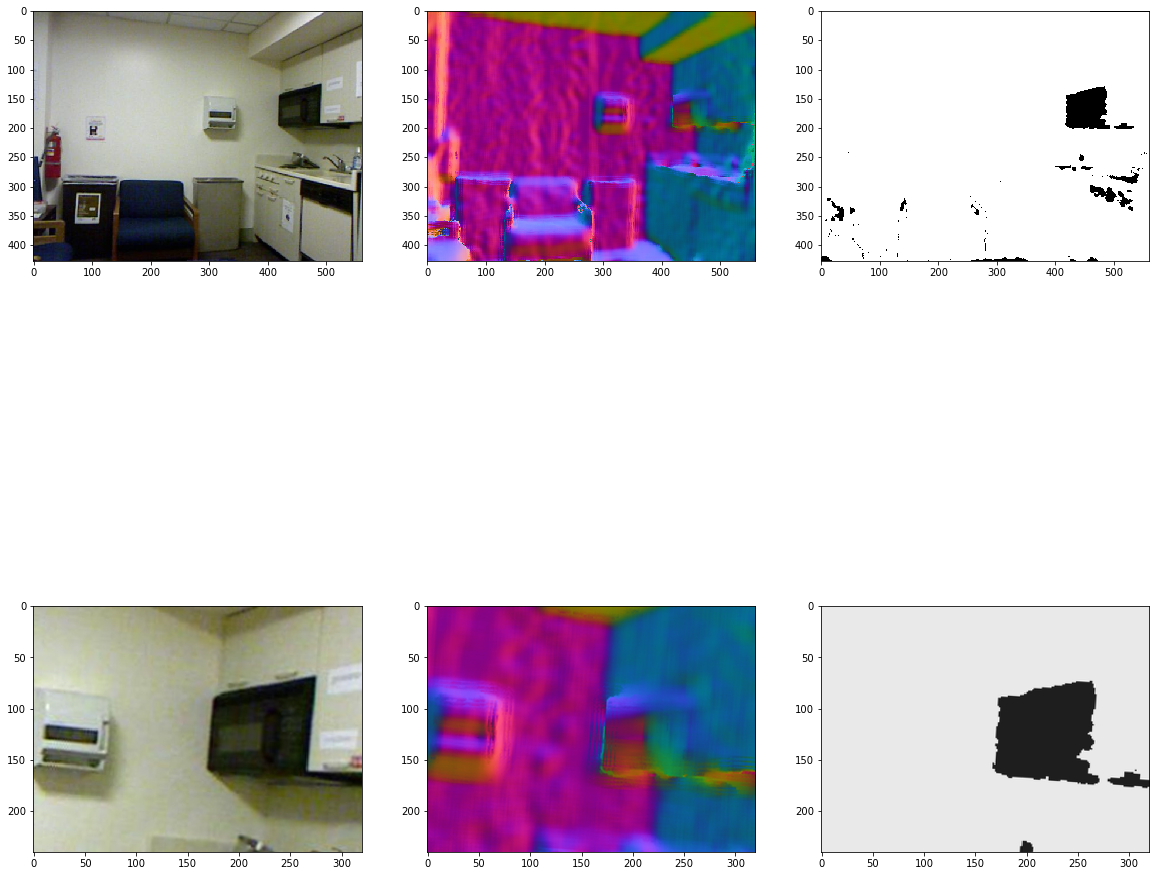

In [277]:
fig, axes = plt.subplots(2, 3,figsize=(20,20))
seed = 5
plt.subplot(2,3,1)
plt.imshow(img)
plt.subplot(2,3,2)
plt.imshow(norm)
plt.subplot(2,3,3)
plt.imshow(mask)
np.random.seed(seed)
plt.subplot(2,3,4)
plt.imshow(array_to_img(augment(img)))
np.random.seed(seed)
plt.subplot(2,3,5)
plt.imshow(array_to_img(augment(norm)))
np.random.seed(seed)
plt.subplot(2,3,6)
plt.imshow(array_to_img(augment(mask)))
plt.show()

In [67]:
from PIL import ImageEnhance as IE

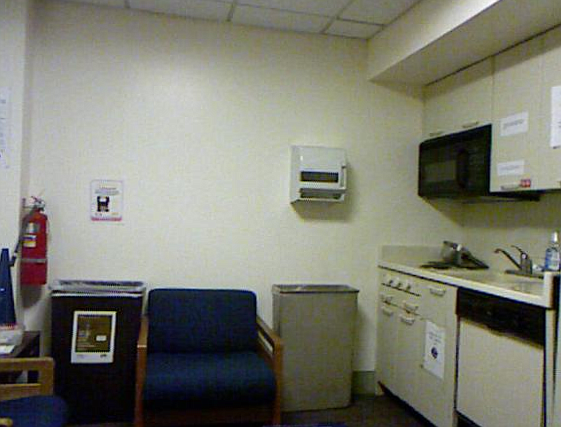

In [88]:
IE.Sharpness(img).enhance(2)

In [11]:
def augment(npimg):
    return random_crop((random_rotation(random_resize(npimg),5)))

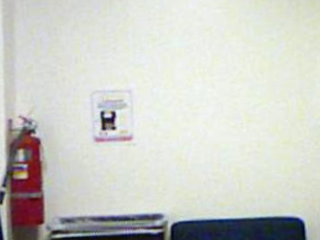

In [23]:
array_to_img(augment(npimg[0]))

In [256]:
img =  load_img('/usr/not-backed-up/temp/NYU/images/0000.png')

In [257]:
norm =  load_img('/usr/not-backed-up/temp/NYU/normals/0000.png')

In [258]:
mask =  load_img('/usr/not-backed-up/temp/NYU/masks/0000.png')

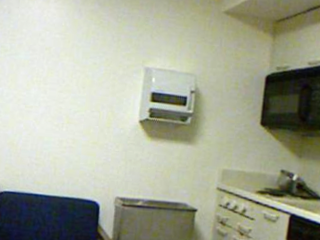

In [265]:
np.random.seed(1)
array_to_img(augment(img_to_array(img)))

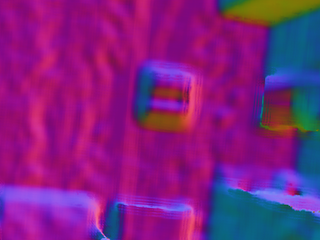

In [266]:
np.random.seed(1)
array_to_img(augment(img_to_array(norm)))

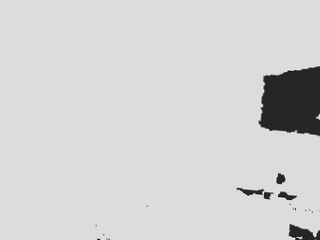

In [267]:
np.random.seed(1)
array_to_img(augment(img_to_array(mask)))

In [297]:
np.linalg.norm(npimg[0,0,0,:]/255)

0.77906084

In [289]:
tmp = np.array([1,2,2])

np.linalg.norm(tmp)

3.0

In [290]:
tmp/3

array([ 0.33333333,  0.66666667,  0.66666667])

In [292]:
np.linalg.norm(tmp/3)

1.0

In [293]:
from sklearn.preprocessing import normalize

In [335]:
normalize(img_to_array(norm))

ValueError: Found array with dim 3. the normalize function expected <= 2.

In [308]:
img_to_array(norm)[0,0,:]/np.linalg.norm(img_to_array(norm)[0,0,:])

array([ 0.86701947,  0.43350974,  0.24565552], dtype=float32)

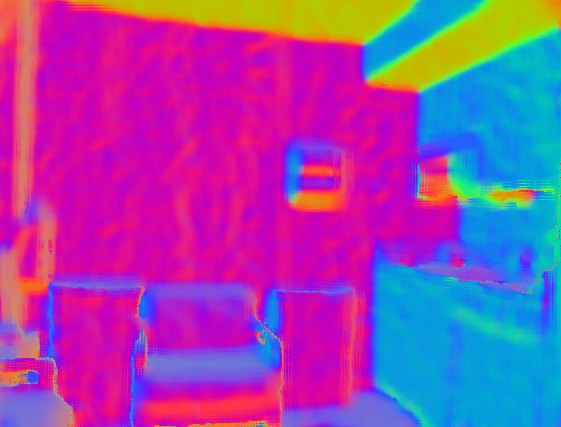

In [379]:
l2norm=np.linalg.norm(img_to_array(norm),axis=2)
array_to_img(np.round(np.divide(img_to_array(norm),l2norm.reshape(l2norm.shape+(1,)))*255))

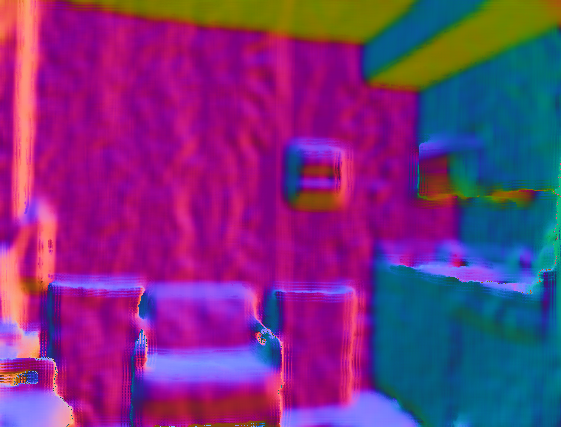

In [367]:
norm

In [320]:
np123 = np.array([[[1,1,1,1],[1,1,1,1]],[[2,2,2,2],[2,2,2,2]],[[2,2,2,2],[2,2,2,2]]])

In [329]:
np.linalg.norm(np123,axis=0)

array([[ 3.,  3.,  3.,  3.],
       [ 3.,  3.,  3.,  3.]])

In [324]:
np123[:,0,0]

array([1, 2, 2])

In [323]:
img_to_array(norm).shape

(427, 561, 3)

In [358]:
npnorm = img_to_array(norm)

if np.array_equal(np.divide(npnorm,255) , np.divide(npnorm,ones)):
    print('Ow')

In [357]:
ones = np.array([255]*427*561).reshape(427,561,1)

In [359]:
np.divide(npnorm,255)

array([[[ 0.94117647,  0.47058824,  0.26666668],
        [ 0.93725491,  0.4509804 ,  0.26274511],
        [ 0.92941177,  0.43529412,  0.25490198],
        ..., 
        [ 0.627451  ,  0.33333334,  0.04313726],
        [ 0.63529414,  0.33333334,  0.04705882],
        [ 0.64705884,  0.32156864,  0.05490196]],

       [[ 0.94117647,  0.46666667,  0.26666668],
        [ 0.93725491,  0.4509804 ,  0.25882354],
        [ 0.93333334,  0.42745098,  0.26274511],
        ..., 
        [ 0.61960787,  0.33333334,  0.04313726],
        [ 0.62352943,  0.33333334,  0.04313726],
        [ 0.63529414,  0.32156864,  0.05098039]],

       [[ 0.94117647,  0.45490196,  0.26666668],
        [ 0.92941177,  0.44313726,  0.25098041],
        [ 0.93333334,  0.42352942,  0.26274511],
        ..., 
        [ 0.62352943,  0.34509805,  0.03921569],
        [ 0.63137257,  0.34509805,  0.03921569],
        [ 0.64313728,  0.33333334,  0.04705882]],

       ..., 
       [[ 0.58431375,  0.35294119,  0.96862745],
        

In [361]:
np.divide(npnorm,ones).shape

(427, 561, 3)

In [368]:
normnorm = np.divide(img_to_array(norm),l2norm.reshape(l2norm.shape+(1,)))

In [376]:
np.linalg.norm(normnorm[412,514,:])

1.0

0
1


ValueError: too many values to unpack (expected 2)

In [378]:
round(3.54)

4

In [381]:
n551 = load_img('./551AlignedNormals.png')

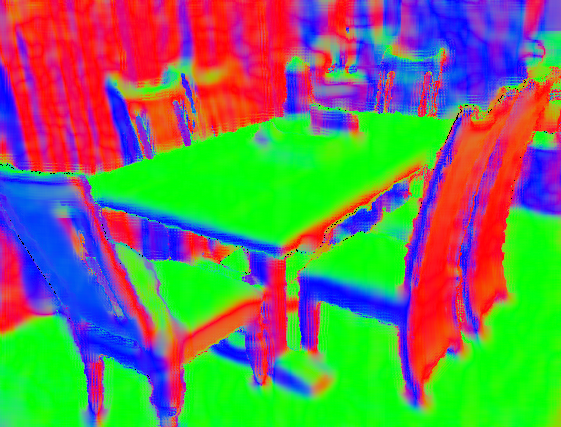

In [382]:
n551

In [399]:
l2norm = np.linalg.norm(img_to_array(n551),axis=2)
#np.amax(np.divide(img_to_array(n551),l2norm.reshape(l2norm.shape+(1,))))
np.amax(l2norm)

255.80266

In [401]:
np.linalg.norm(img_to_array(n551),axis=2)

array([[ 255.00196838,  255.19599915,  255.39186096, ...,  255.1078186 ,
         254.86859131,  255.51124573],
       [ 254.32460022,  254.94509888,  254.845047  , ...,  255.55038452,
         254.86859131,  254.55255127],
       [ 255.00196838,  255.11958313,  254.87643433, ...,  255.24497986,
         255.01763916,  254.86663818],
       ..., 
       [ 254.61146545,  254.66252136,  254.98431396, ...,  254.74890137,
         254.61146545,  254.71160889],
       [ 255.47993469,  254.82739258,  255.24302673, ...,  254.62913513,
         254.92352295,  255.22735596],
       [ 255.1587677 ,  255.1078186 ,  255.2371521 , ...,  255.52104187,
         255.22735596,  254.95294189]], dtype=float32)

In [402]:
img_to_array(n551)/255

array([[[ 0.78039217,  0.04705882,  0.62352943],
        [ 0.82352942,  0.        ,  0.56862748],
        [ 0.90196079,  0.12941177,  0.41568628],
        ..., 
        [ 0.4627451 ,  0.32941177,  0.82352942],
        [ 0.47843137,  0.33333334,  0.81176472],
        [ 0.49019608,  0.33333334,  0.80784315]],

       [[ 0.7764706 ,  0.05490196,  0.62352943],
        [ 0.81960785,  0.        ,  0.57254905],
        [ 0.89803922,  0.11372549,  0.42352942],
        ..., 
        [ 0.47058824,  0.33333334,  0.81960785],
        [ 0.47843137,  0.33333334,  0.81176472],
        [ 0.48627451,  0.33725491,  0.80392158]],

       [[ 0.78039217,  0.04705882,  0.62352943],
        [ 0.81176472,  0.02352941,  0.58431375],
        [ 0.87843138,  0.09803922,  0.46666667],
        ..., 
        [ 0.46666667,  0.32549021,  0.82352942],
        [ 0.48235294,  0.32941177,  0.81176472],
        [ 0.49411765,  0.32941177,  0.80392158]],

       ..., 
       [[ 0.23137255,  0.80392158,  0.54509807],
        